In [19]:
import torch
from torch import nn 
import numpy as np
import matplotlib.pyplot as plt
from nsvd import NSVD_COUNTY

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


In [20]:
train = NSVD_COUNTY()

train_inputs = train.data.to(device)
train_targets = train.targets.to(device)

mean = train_inputs.mean()
std = train_inputs.std()
train_inputs = (train_inputs - mean) / std

batch_size = 36
train_input_batches = torch.split(train_inputs, batch_size)
train_target_batches = torch.split(train_targets, batch_size)

print(train_input_batches[0].shape)
print(train_target_batches[0].shape)
print(train_targets)

torch.Size([36, 3, 128, 128])
torch.Size([36])
tensor([ 7,  9,  0,  ...,  8, 10,  0], device='cuda:0')


In [21]:
train_input_batches = train_input_batches[:61]
train_target_batches = train_target_batches[:61]

In [22]:
print(train_inputs.size())

torch.Size([2201, 3, 128, 128])


In [23]:
print(train_targets.dtype)

torch.int64


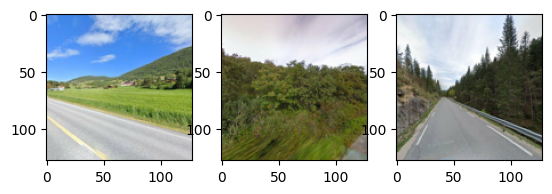

In [24]:
fig, axs = plt.subplots(1, 3)

for i, ax in enumerate(axs.ravel()):
  d = train_inputs[i] * std + mean
  ax.imshow(d.int().cpu().detach().numpy().transpose(1, 2, 0))

In [25]:
class ConvModule(nn.Module):
  def __init__(self, in_features, out_features) -> None:
    super(ConvModule, self).__init__()
    self.conv = nn.Conv2d(in_features, out_features, 5, padding=2)
    self.norm = nn.BatchNorm2d(out_features)

  def forward(self, x) -> torch.Tensor:
    x = self.norm(self.conv(x))
    return torch.relu(x)

class NSVDModel(nn.Module):
  def __init__(self) -> None:
    super(NSVDModel, self).__init__()
    self.pool = nn.MaxPool2d(2)
    self.conv1 = ConvModule(3, 64)
    self.conv2 = ConvModule(64, 128)
    self.conv3 = ConvModule(128, 256)
    self.l1 = nn.Linear(256*8*8, 512)
    self.l2 = nn.Linear(512, 11)
    
  def forward(self, x):
    x = self.pool(self.conv1(x)) # 128 -> 64
    x = self.pool(self.conv2(x)) # 64 -> 32
    x = self.pool(self.conv3(x)) # 32 -> 16
    x = x.reshape(-1, 256*8*8)
    x = torch.relu(self.l1(x))
    x = self.l2(x)
    return torch.log_softmax(x, dim=1)

In [26]:
model = NSVDModel()
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [27]:

epochs = 10
for epoch in range(epochs):
  epoch_loss = 0
  for batch in range(len(train_input_batches)):
    y = model(train_input_batches[batch])
    print(y.shape)
    print(train_target_batches[batch].shape)
    loss = loss_fn(y, train_target_batches[batch])
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    epoch_loss += loss
  print("epoch: {}; loss: {}".format(epoch, epoch_loss/len(train_input_batches)))

torch.Size([36, 256, 16, 16])
torch.Size([144, 16384])
torch.Size([144, 512])
torch.Size([144, 11])
torch.Size([144, 11])
torch.Size([36])


ValueError: Expected input batch_size (144) to match target batch_size (36).